In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pqm import pqm_chi2, pqm_pvalue
from scipy.stats import norm, chi2, uniform, kstest
import torch
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200
plt.rc("font", **{"family": "serif", "serif": ["Computer Modern"]})
plt.rc("text", usetex=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Create a distribution, and sample from it twice

In [2]:
class TimeSeriesModel:
    def __init__(self, a = 0., sigma=1., nt=100):
        self.t = np.linspace(0, 10, nt)
        self.a = a
        self.sigma = sigma
        
    def generate_samples(self, num_samples):
        # Generate samples from each component
        y = self.a * np.cos(self.t) + self.sigma * np.random.randn(num_samples, len(self.t))
        return y


In [ ]:
num_repeats = 20
gmm_null = TimeSeriesModel(a = 0)

amps = np.logspace(-2, 0, 20)
chisqs_mean = np.zeros_like(amps)
chisqs_std = np.zeros_like(amps)

for i, a in enumerate(amps):
    gmm = TimeSeriesModel(a = a)
    null_samples = gmm_null.generate_samples(num_samples=5000)
    y_samples = gmm.generate_samples(num_samples=5000)
    zs = []
    z = pqm_chi2(y_samples, null_samples, device = device, re_tessellation=num_repeats)
    zs += z
        
    chisqs_mean[i] = np.median(zs)
    chisqs_std[i] = np.std(zs)
    print(a, chisqs_mean[i], chisqs_std[i])

0.01 100.89581280536342 13.021347343248523
0.012742749857031334 99.29338082170935 16.772287181292945
0.016237767391887217 106.65897087831716 12.865500803669983
0.0206913808111479 94.2445056547761 15.92235404770378
0.026366508987303583 108.89551895493938 14.687380638385607
0.03359818286283781 106.17132451779497 14.056129603801027
0.04281332398719394 111.66719296709199 17.286369725396344
0.0545559478116852 125.0756779465738 17.747082656143277
0.06951927961775606 137.35343190699854 21.896890224880973
0.08858667904100823 144.27641381633964 18.790715313373536
0.11288378916846889 196.80318344023084 22.390201281451322
0.14384498882876628 259.55485825330106 27.88974850365713
0.18329807108324356 363.3671243837876 67.4927129505813
0.23357214690901212 628.0253101750119 99.54363119973272
0.29763514416313175 1032.2089653985397 143.63567443520492
0.37926901907322497 1841.018792367092 207.64443330291348
0.4832930238571752 3299.3509311386283 327.8315178073717
0.615848211066026 5731.8400170353925 427.2

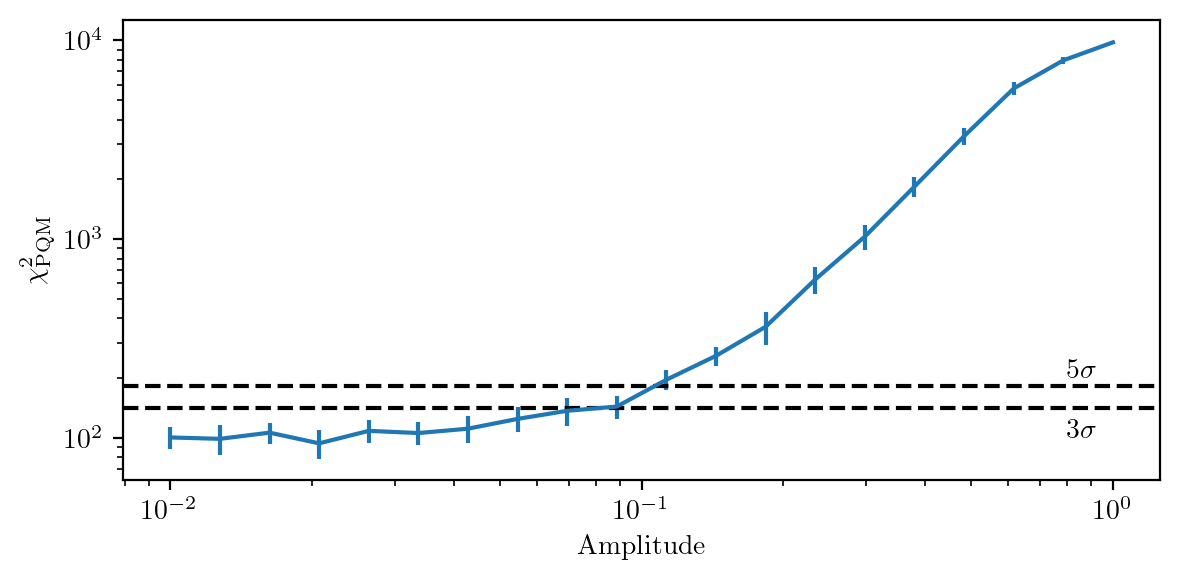

In [4]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.errorbar(amps, chisqs_mean, yerr=chisqs_std)
ax.axhline(chi2.ppf(0.997300203936740, 99), ls='--', color='k')
ax.axhline(chi2.ppf(0.999999426696856, 99), ls='--', color='k')
ax.text(0.8, 100, r'$3 \sigma$')
ax.text(0.8, 200, r'$5 \sigma$')
ax.set_xlabel('Amplitude')
ax.set_ylabel('$\chi^2_{\mathrm{ PQM}}$')
ax.set_yscale('log')
ax.set_xscale('log')
plt.tight_layout()
plt.show()

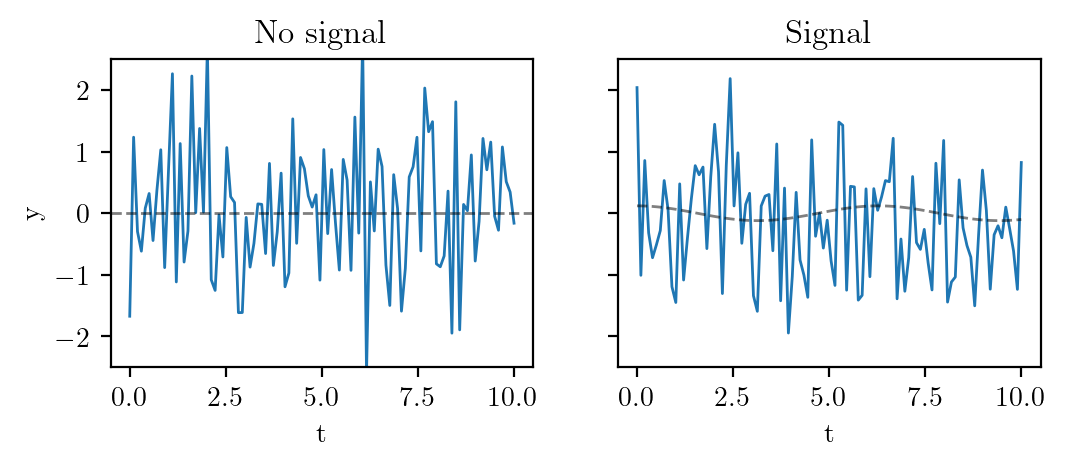

In [5]:
gmm = TimeSeriesModel(a = 0.12)
gmm_null = TimeSeriesModel(a = 0)
x_samples = gmm.generate_samples(num_samples=2)
null_samples = gmm_null.generate_samples(num_samples=2)

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(6, 2), sharex=True, sharey=True)
axs[0].plot(gmm.t, null_samples[0], lw=1)
axs[0].axhline(0, color='k', lw=1, ls='--', alpha=0.5)
axs[0].set_ylim([-2.5, 2.5])
axs[0].set_xlabel('t')
axs[0].set_ylabel('y')
axs[0].set_title('No signal')

axs[1].plot(gmm.t, x_samples[0], lw=1)
axs[1].plot(gmm.t, gmm.a * np.cos(gmm.t), color='k', lw=1, ls='--', alpha=0.5)
axs[1].set_ylim([-2.5, 2.5])
axs[1].set_title('Signal')
axs[1].set_xlabel('t')

plt.show()

# Using p-value

In [ ]:
num_repeats = 20
gmm_null = TimeSeriesModel(a = 0)

amps = np.logspace(-2, 0, 20)
p_val_mean = np.zeros_like(amps)
p_val_std = np.zeros_like(amps)

for i, a in enumerate(amps):
    gmm = TimeSeriesModel(a = a)
    null_samples = gmm_null.generate_samples(num_samples=5000)
    y_samples = gmm.generate_samples(num_samples=5000)
    p_val = []
    pval = pqm_pvalue(y_samples, null_samples, device = device, re_tessellation=num_repeats)
    p_val += pval
    p_val_mean[i] = np.median(p_val)
    p_val_std[i] = np.std(p_val)

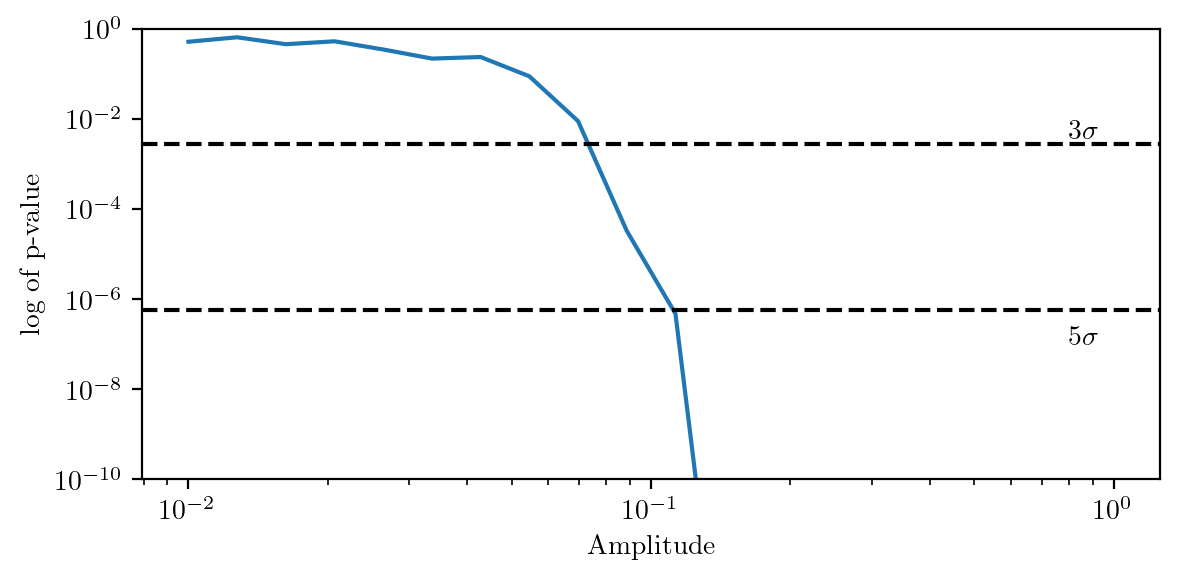

In [7]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(amps, p_val_mean)
ax.axhline(1 - 0.997300203936740, ls='--', color='k')  # 3 sigma equivalent p-value
ax.axhline(1 - 0.999999426696856, ls='--', color='k')  # 5 sigma equivalent p-value
ax.text(0.8, 0.01, r'$3 \sigma$', verticalalignment='top')
ax.text(0.8, 0.0000001, r'$5 \sigma$')
ax.set_xlabel('Amplitude')
ax.set_ylabel('log of p-value')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(1e-10, 1)  # Set the y-axis limits
plt.tight_layout()
plt.show()
